In [1]:
using DifferentialEquations, StatsBase, Parameters, Plots, Interact, Distributions

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7400998663457845202\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12477755806092994041\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-7400998663457845202\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

### Jump Problem Setup

In [2]:
function affect!(integrator)
  n = rand(1:integrator.p.N)
  n2 = rand(1:integrator.p.N)
  integrator.u[n] = max(integrator.u[n], integrator.u[n2])
end

function μ_SDE(du,u,p,t)
  du .= p.μ
end

function σ_SDE(du,u,p,t)
  du .= p.σ
end

σ_SDE (generic function with 1 method)

In [3]:
params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 10, # num particles
    β = 0.2, # rate parameter
    t = 0.:0.01:10., # time steps to save
    moments = Array{Array{Float64, 1}, 1}(), # container for moments
    α = 2.0, # shape parameter for the initial condition distribution
    iv_dist = Exponential(1/α)) # updates based on supplied α

p = params()

(μ = 0.01, σ = 0.1, N = 10, β = 0.2, t = 0.0:0.01:10.0, moments = Array{Float64,1}[], α = 2.0, iv_dist = Exponential{Float64}(θ=0.5))

In [4]:
x_iv = rand(p.iv_dist, p.N)  # draws the inital condition
prob = SDEProblem(μ_SDE, σ_SDE, x_iv ,(0.0, p.t[end]), p)
rate(u,p,t) = p.β*p.N
jump = ConstantRateJump(rate,affect!)
jump_prob = JumpProblem(prob,Direct(),jump)

JumpProblem with problem SDEProblem and aggregator Direct
Number of constant rate jumps: 1
Number of variable rate jumps: 0


### Callback Setup

In [5]:
function calculate_moments(u, t, integrator) 
    g = (length(integrator.p.moments) == 0 ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
    moments = [minimum(u), mean(u), maximum(u), g]
    push!(integrator.p.moments, moments) 
end

cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1)
    
function write_moments(sol, i)
    resize!(sol.t, 0); resize!(sol.u, 0)
    append!(sol.t, sol.prob.p.t); append!(sol.u, sol.prob.p.moments)
    return (sol, false)
end

write_moments (generic function with 1 method)

In [6]:
ensemble_prob = EnsembleProblem(prob, output_func = write_moments)

EnsembleProblem with problem SDEProblem

### Solve and Plot

In [7]:
sim = solve(ensemble_prob, SRIW1(), EnsembleSerial(), trajectories = 2, callback = cb, save_everystep = false)

EnsembleSolution Solution of length 2 with uType:
RODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{Float64,2,Float64,Array{Float64,1},Array{Float64,1},Array{Array{Float64,1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,DataStructures.Stack{Tuple{Float64,Array{Float64,1},Array{Float64,1}}},ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},RSWM{:RSwM3,Float64},RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,NamedTuple{(:μ, :σ, :N, :β, :t, :moments, :α, :iv_dist),Tuple{Float64,Float64,Int64,Float64,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Array{Array{Float64,1},1},Float64,Exponential{Float64}}},Nothing,SDEFunction{true,typeof(μ_SDE),typeof(σ_SDE),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing

In [8]:
summ = EnsembleSummary(sim)

EnsembleSolution Solution of length 1001 with uType:
Float64

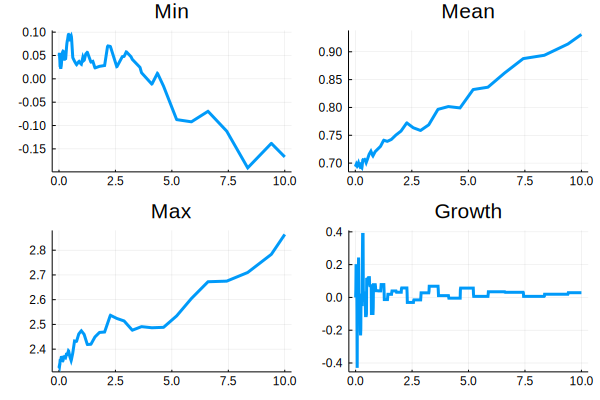

In [9]:
p1 = plot(summ, idxs = [1], error_style = :none, title = "Min")
p2 = plot(summ, idxs = [2], error_style = :none, title = "Mean")
p3 = plot(summ, idxs = [3], error_style = :none, title = "Max")
p4 = plot(summ, idxs = [4], error_style = :none, title = "Growth")

plot(p1, p2, p3, p4)

### Single Simulation

With some slight modification, we can follow the particle trajectories within a single simulation.

In [10]:
sol = solve(jump_prob, SRIW1(), saveat = p.t); # output is quite long when printed

We show only half of the particles, for ease of display.

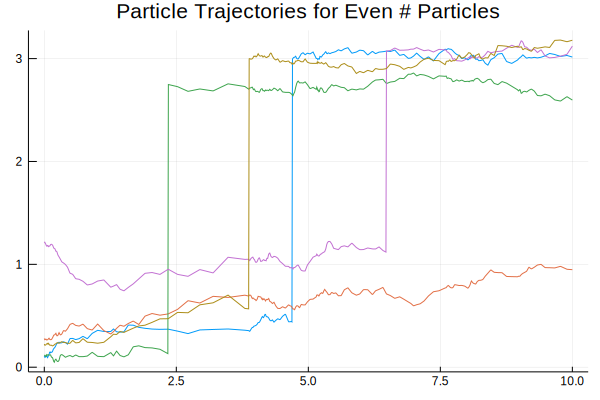

In [11]:
plot(sol(p.t, idxs=[2, 4, 6, 8, 10]), legend = false, title = "Particle Trajectories for Even # Particles")